## Dataset Preprocessing Notebook

Opens the fits files using data_loader and filter the dataset using the catalog standardizer, then Saves the cleaned datasets in gzip files

### Import Statements and Load config.yaml file

In [3]:
from pathlib       import Path
import sys

sys.path.append(str(Path("../").resolve()))

import pandas             as pd
import numpy              as np
import matplotlib.pyplot  as plt
from astropy.io           import fits

from catalog_standardizer import CatalogStandardizer
from config_loader        import ConfigLoader
from data_loader          import DataLoader

In [4]:
config = ConfigLoader(str(Path("../configs/config.yaml").resolve()))
data = DataLoader(config, verbosity = 0)

df_eROSITA = data.get_dataframe(config.EROSITA_PATH)
df_h20 = data.get_dataframe(config.H20_PATH)

### Initialize RA and DEC of Catalogs

In [5]:
df_eROSITA_RA, df_eROSITA_DEC = df_eROSITA['RA_RAW'], df_eROSITA['DEC_RAW']
df_h20_RA, df_h20_DEC = df_h20['ALPHA_J2000'], df_h20['DELTA_J2000']

## RA and DEC Plots

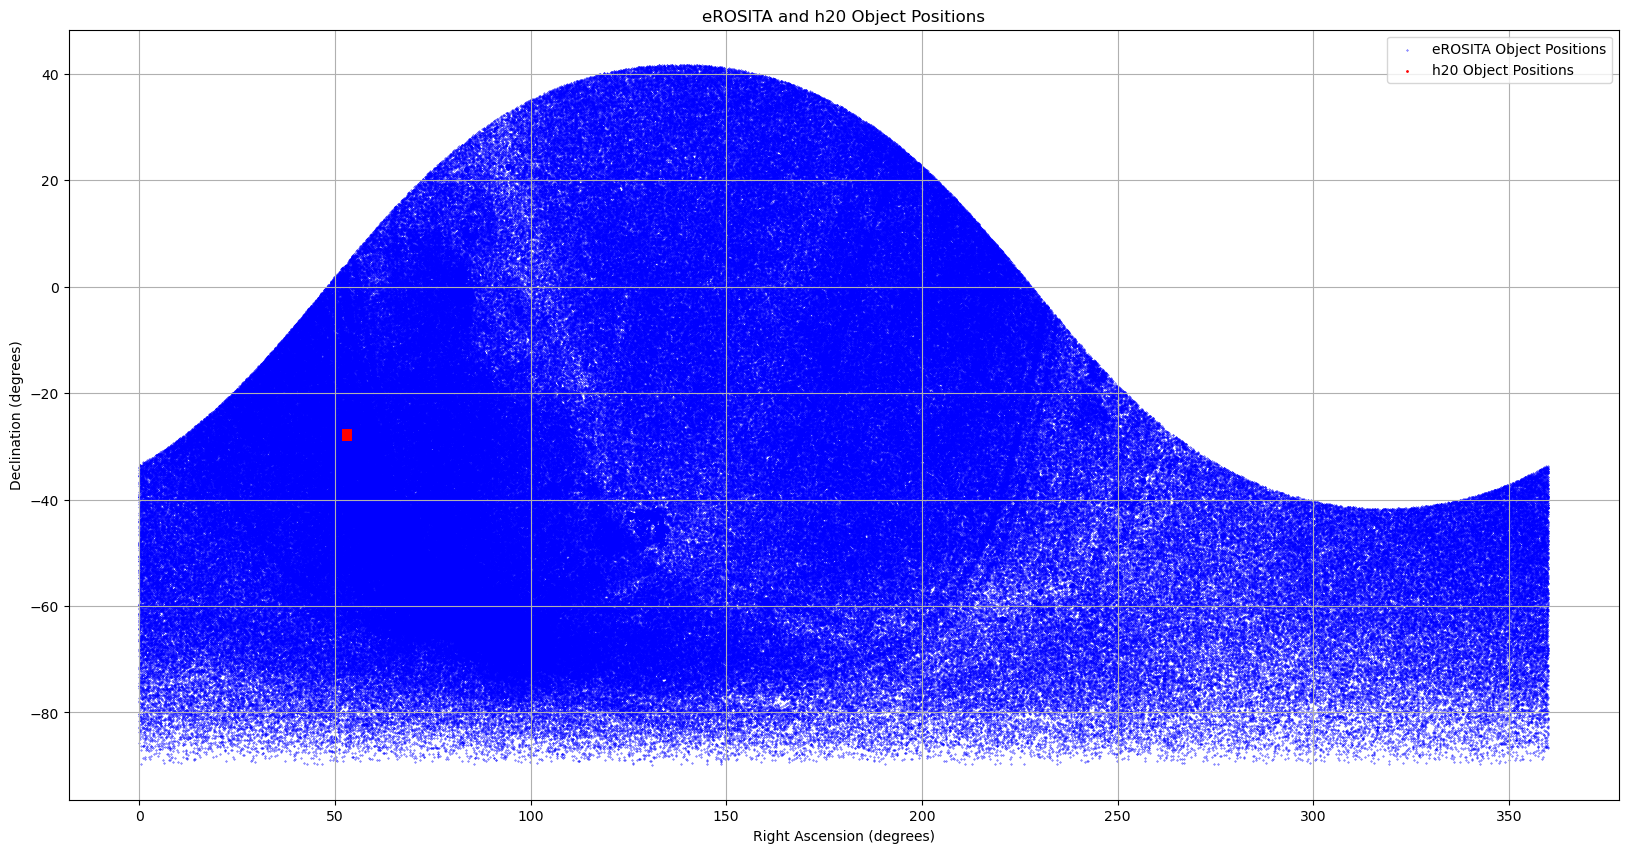

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(df_eROSITA_RA, df_eROSITA_DEC, c='blue', s=0.1, label='eROSITA Object Positions')
ax.scatter(df_h20_RA, df_h20_DEC, c='red', s=1, label='h20 Object Positions')

ax.set_title('eROSITA and h20 Object Positions')
ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
ax.grid(True)
ax.legend()

plt.show()

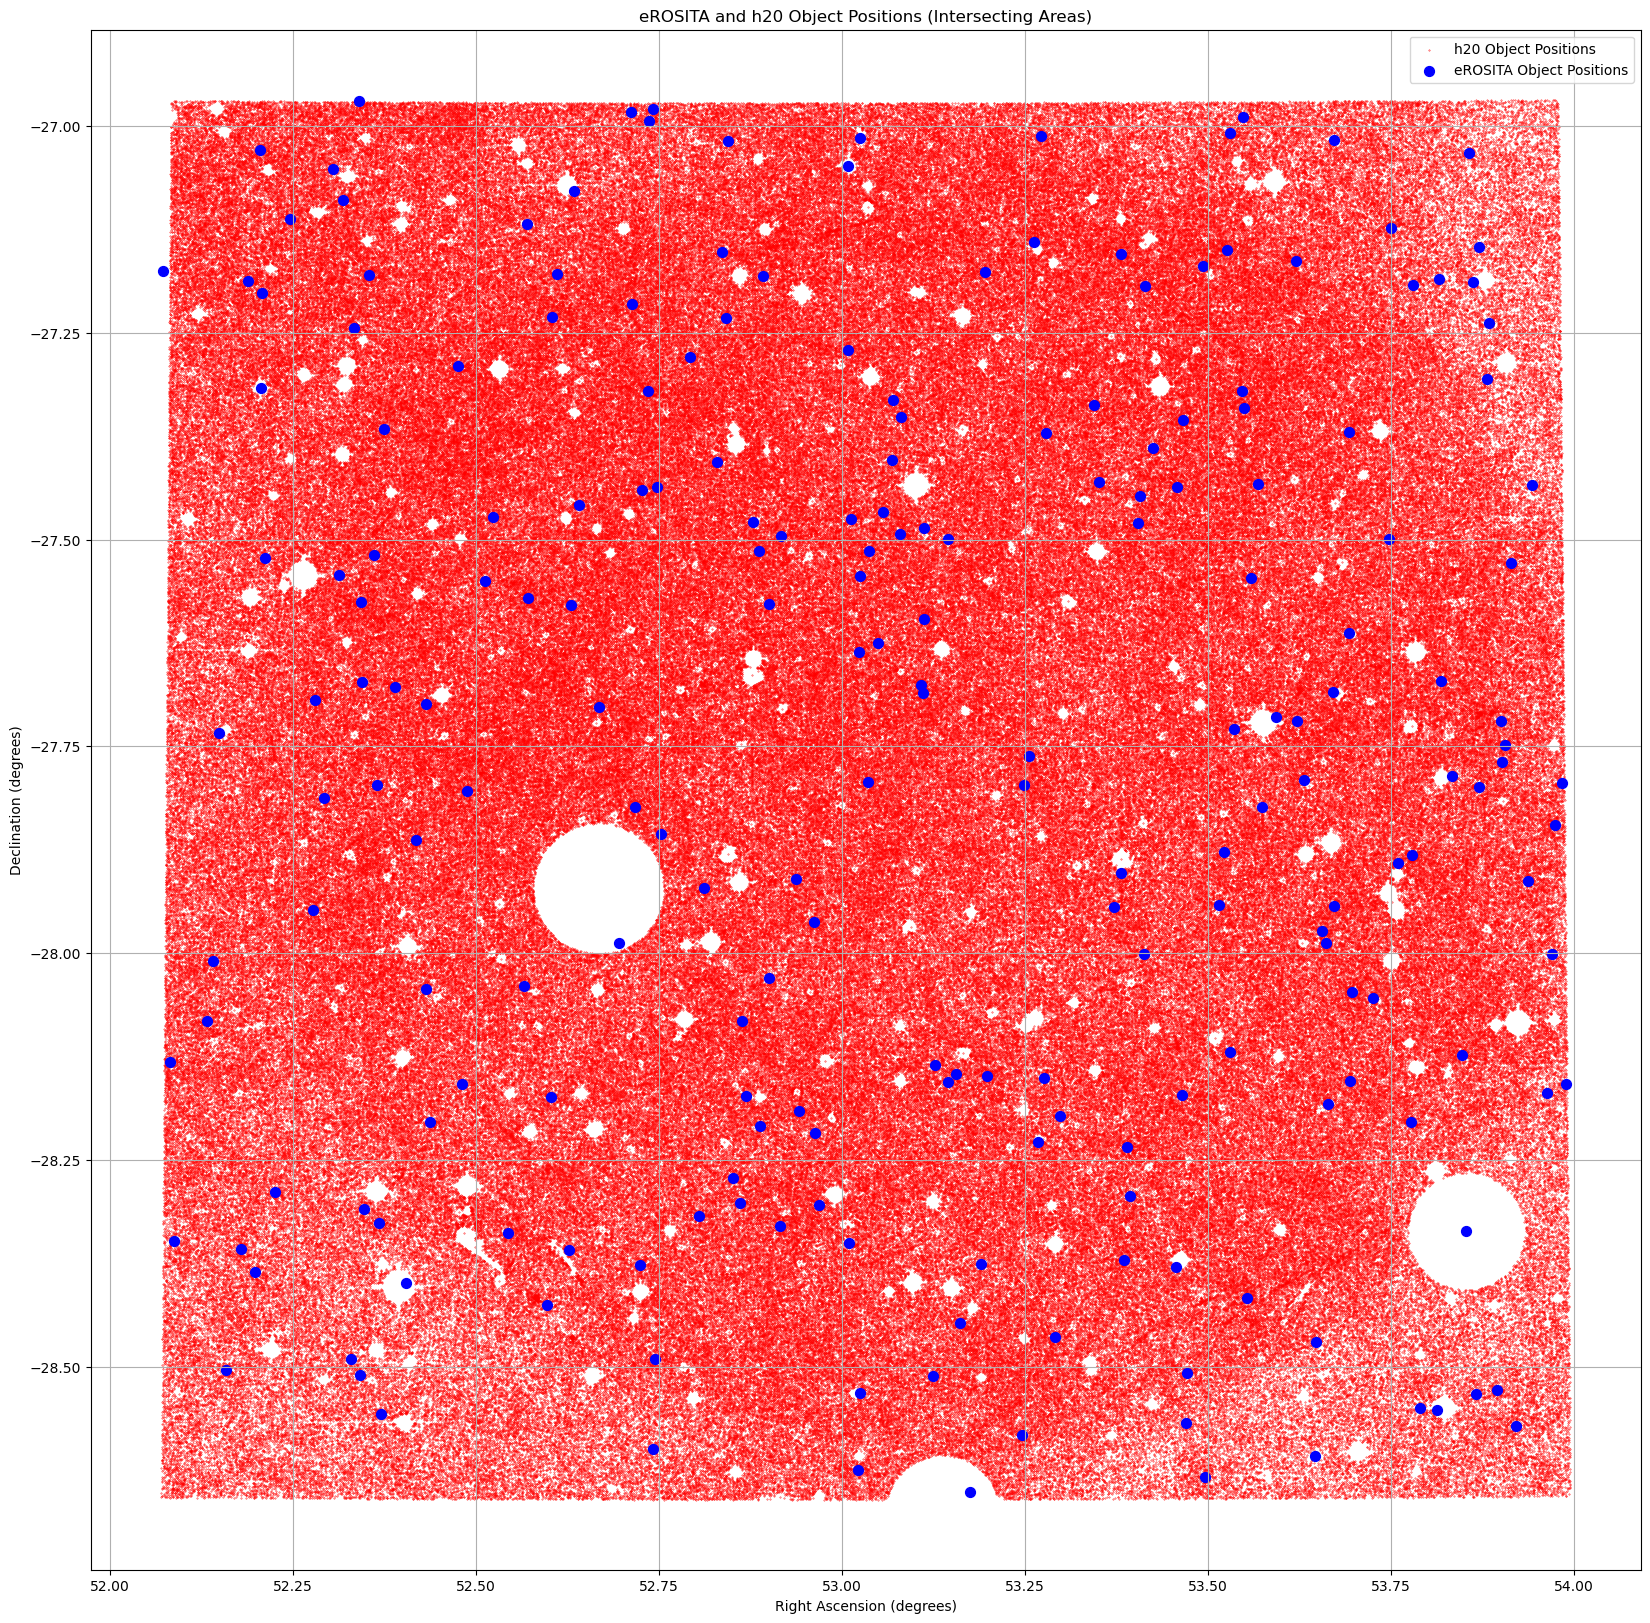

In [7]:
min_RA = max(df_eROSITA_RA.min(), df_h20_RA.min())
max_RA = min(df_eROSITA_RA.max(), df_h20_RA.max())
min_DEC = max(df_eROSITA_DEC.min(), df_h20_DEC.min())
max_DEC = min(df_eROSITA_DEC.max(), df_h20_DEC.max())

filtered_eROSITA = df_eROSITA[
    (df_eROSITA_RA >= min_RA) & (df_eROSITA_RA <= max_RA) &
    (df_eROSITA_DEC >= min_DEC) & (df_eROSITA_DEC <= max_DEC)
]

filtered_h20 = df_h20[
    (df_h20_RA >= min_RA) & (df_h20_RA <= max_RA) &
    (df_h20_DEC >= min_DEC) & (df_h20_DEC <= max_DEC)
]

filtered_eROSITA_RA, filtered_eROSITA_DEC = filtered_eROSITA['RA_RAW'], filtered_eROSITA['DEC_RAW']
filtered_h20_RA, filtered_h20_DEC = filtered_h20['ALPHA_J2000'], filtered_h20['DELTA_J2000']

fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(filtered_h20_RA, filtered_h20_DEC, c='red', s=0.1, label='h20 Object Positions')
ax.scatter(filtered_eROSITA_RA, filtered_eROSITA_DEC, c='blue', s=50, label='eROSITA Object Positions')

ax.set_title('eROSITA and h20 Object Positions (Intersecting Areas)')
ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
ax.grid(True)
ax.legend()

plt.show()

## Catalog Standardization

Filter the eROSITA dataset so that only the objects in the H20 regions are included

In [8]:
df_h20['ERR_TOTAL'] = np.sqrt(df_h20['ERRY_MODEL']**2 + df_h20['ERRX_MODEL']**2)

eROSITA_standardizer = CatalogStandardizer(
    df_eROSITA['IAUNAME'],
    df_eROSITA['RA'],
    df_eROSITA['DEC'],
    df_eROSITA["POS_ERR"],
    df_eROSITA["ML_FLUX_1"]
)

h20_standardizer = CatalogStandardizer(
    df_h20['ID'],
    df_h20['ALPHA_J2000'],
    df_h20['DELTA_J2000'],
    df_h20['ERR_TOTAL'],
    df_h20['CFHT_u_FLUX']
)

h20_standardized = h20_standardizer.standardize()
eROSITA_standardized = eROSITA_standardizer.standardize()

min_RA = max(h20_standardized['ra'].min(), eROSITA_standardized['ra'].min())
max_RA = min(h20_standardized['ra'].max(), eROSITA_standardized['ra'].max())
min_DEC = max(h20_standardized['dec'].min(), eROSITA_standardized['dec'].min())
max_DEC = min(h20_standardized['dec'].max(), eROSITA_standardized['dec'].max())

h20_standardized = h20_standardized[
    (h20_standardized['ra'] >= min_RA) & (h20_standardized['ra'] <= max_RA) &
    (h20_standardized['dec'] >= min_DEC) & (h20_standardized['dec'] <= max_DEC)
].reset_index(drop=True)

eROSITA_standardized = eROSITA_standardized[
    (eROSITA_standardized['ra'] >= min_RA) & (eROSITA_standardized['ra'] <= max_RA) &
    (eROSITA_standardized['dec'] >= min_DEC) & (eROSITA_standardized['dec'] <= max_DEC)
].reset_index(drop=True)

In [9]:
eROSITA_standardized.head(10)

uuid                     name         ra  \
0  968c4ed0-b24b-425e-ab00-a50dc0e9788a  1eRASS J033202.3-271614  53.009634   
1  66b3ddd5-445b-472b-84a5-a5496600e0bd  1eRASS J033202.1-270252  53.008996   
2  c958a1bb-e02e-4d74-adfa-2313d7ff6200  1eRASS J033247.0-271035  53.196088   
3  7122d0b3-7d21-4bc9-8bf6-89b29e5da3c9  1eRASS J033126.9-281807  52.862168   
4  232211de-b907-4ba1-9e17-b797cea52859  1eRASS J032850.2-271207  52.209376   
5  0894dbd4-93d2-4e06-a46a-ead7c33270c0  1eRASS J033219.2-272935  53.080047   
6  0acdff98-7f12-47e5-81bc-465e121b55a7  1eRASS J033023.5-282530  52.598027   
7  5b809e79-09db-4d2f-8aaa-f26a743f2161  1eRASS J032849.7-271858  52.207499   
8  1bf86c5e-7bff-42f3-9d25-18144bd98221  1eRASS J032945.1-281213  52.438212   
9  3be9f2d6-a2f4-4ece-aeb3-53215a21533e  1eRASS J033226.0-274033  53.108600   

         dec    pos_err          flux  
0 -27.270768   1.528060  4.194685e-13  
1 -27.047819   1.767077  2.857447e-13  
2 -27.176580   2.730784  1.486411e-13  
3 -28.302076   2.169048  1.652600e-13  
4 -27.202160   2.216686  1.340457e-13  
5 -27.493224  14.138060  3.347836e-13  
6 -28.425021   2.450423  1.350338e-13  
7 -27.316378   2.378793  1.035358e-13  
8 -28.203696   2.023767  1.287295e-13  
9 -27.675897   3.340858  8.600334e-14

In [10]:
h20_standardized.head(10)

uuid  name         ra        dec   pos_err  \
0  e89b867e-ae56-4ad2-930d-e97bdb77ad97     1  52.357832 -28.015619  0.116018   
1  4cc53cf3-75d5-4756-824a-8cc02338a8f4     2  52.319698 -28.015597  0.033989   
2  ebf1bbad-25e0-4766-bb8e-65f0dbf0e3c3     3  52.440821 -28.015964  0.028337   
3  3967392c-1b0f-4f7c-8934-2899450726a2     4  52.353230 -28.015827  0.043149   
4  43274db4-4a6b-4b02-8a41-ca39bc1b2d57     5  52.450583 -28.015713  0.286239   
5  643d6984-ff3d-4a03-95ab-1cb01f818b84     6  52.400372 -28.015572  0.177721   
6  c2ddf588-0a31-4d52-86c1-2cf289ce4c0b     7  52.396811 -28.015594  0.135946   
7  f1e694d8-9ffb-47b0-b49d-2eff217dbbc6     8  52.378671 -28.015635  0.026319   
8  bf25c5e4-a7d4-4ab1-b9aa-5081a0a16472     9  52.365232 -28.015416  0.214234   
9  c5414d78-8660-4b54-ab1f-b9559c44f723    10  52.347353 -28.015439  0.156402   

       flux  
0  0.244099  
1  0.580868  
2  0.352241  
3  0.503563  
4  0.018358  
5  0.058151  
6  0.020905  
7  0.709466  
8  0.041005  
9  0.106327

In [11]:
print("Length H20: ", len(h20_standardized))
print("Length eROSITA: ", len(eROSITA_standardized))

Length H20:  1062645
Length eROSITA:  223


In [13]:
h20_standardized.to_pickle(f'{config.SAVE_DATA_PATH}/h20_standardized.pkl.gz', compression='gzip')
eROSITA_standardized.to_pickle(f'{config.SAVE_DATA_PATH}/eROSITA_standardized.pkl.gz', compression='gzip')

h20_standardized.to_csv(f'{config.SAVE_DATA_PATH}/h20_standardized.csv', index=False)
eROSITA_standardized.to_csv(f'{config.SAVE_DATA_PATH}/eROSITA_standardized.csv', index=False)